In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys

from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


## Make pic of iPRC convolution together with direct measurement

In [2]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [3]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.001
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.53684210526316


initialised ...


In [4]:
prc_xcorr = np.load('data/PRC_1mV0,1ms.npy',allow_pickle='TRUE').item()

In [5]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
phis = np.concatenate(([0.], phis))
phis = np.concatenate((phis, [period_fr]))
prcs = np.concatenate(([prcs[0]], prcs))
prcs = np.concatenate((prcs, [prcs[-1]]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

In [6]:
def iPRC_func(phi):
    return prc_func(phi) / (2*10**(-14)*prc.frperiod) 

In [8]:
prc_sine = np.load('data/PRC_sine_0.010mV.npy',allow_pickle='TRUE').item()

In [9]:
from scipy import signal

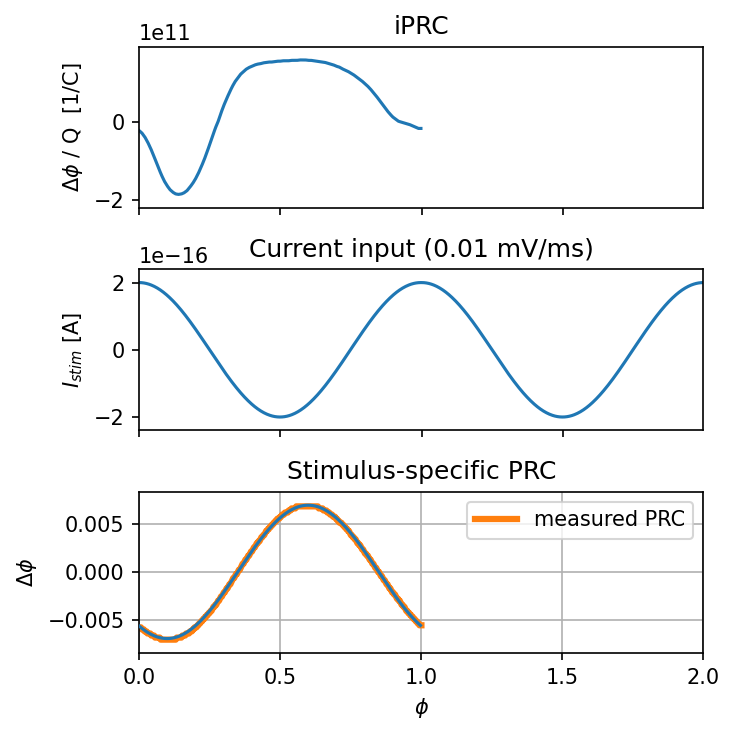

In [10]:
xs = np.linspace(0, prc.frperiod, int(prc.frperiod*10))
sig = iPRC_func(xs)
#win = np.sin(np.linspace(0, 2*np.pi, len(xs)))*2*10**(-14) * 0.01 
win = np.sin(np.linspace(-1.5*np.pi, 0.5*np.pi, len(xs)))*2*10**(-14) * 0.01
win2 = np.concatenate([win, win])
filtered = signal.convolve(sig, win2, mode='same') 

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True, figsize=(5,5), dpi=150)
ax_orig.plot(sig)
ax_orig.set_ylabel(r"$\Delta\phi$ / Q  [1/C]")
ax_orig.set_title('iPRC')
ax_orig.margins(0, 0.1)
ax_win.plot(win2)
ax_win.set_ylabel(r"$I_{stim}$ [A]")
ax_win.set_title('Current input (0.01 mV/ms)')
ax_win.margins(0, 0.1)

ax_filt.plot(filtered, zorder=5)
prcs_x = np.asarray(list(prc_sine.keys()))
prcs_y = np.asarray(list(prc_sine.values()))
ax_filt.plot(prcs_x/prc.frperiod*len(xs), prcs_y / prc.frperiod, c="tab:orange", lw=3, label="measured PRC")
ax_filt.grid()
ax_filt.set_ylabel("")
ax_filt.set_title('Stimulus-specific PRC')
ax_filt.margins(0, 0.1)
ax_filt.legend()
ax_filt.set_xlabel(r"$\phi$")
ax_filt.set_ylabel(r"$\Delta \phi$")
ax_filt.set_xticks([0, 5* prc.frperiod, 10 * prc.frperiod, 15 * prc.frperiod, 20 * prc.frperiod ])
ax_filt.set_xticklabels(['0.0','0.5','1.0','1.5','2.0'])

fig.tight_layout()
fig.show()

## now in my style

ic| min(lab): -2.0
ic| max(lab): -2.0
ic| min(lab): -2.0
ic| max(lab): 2.0


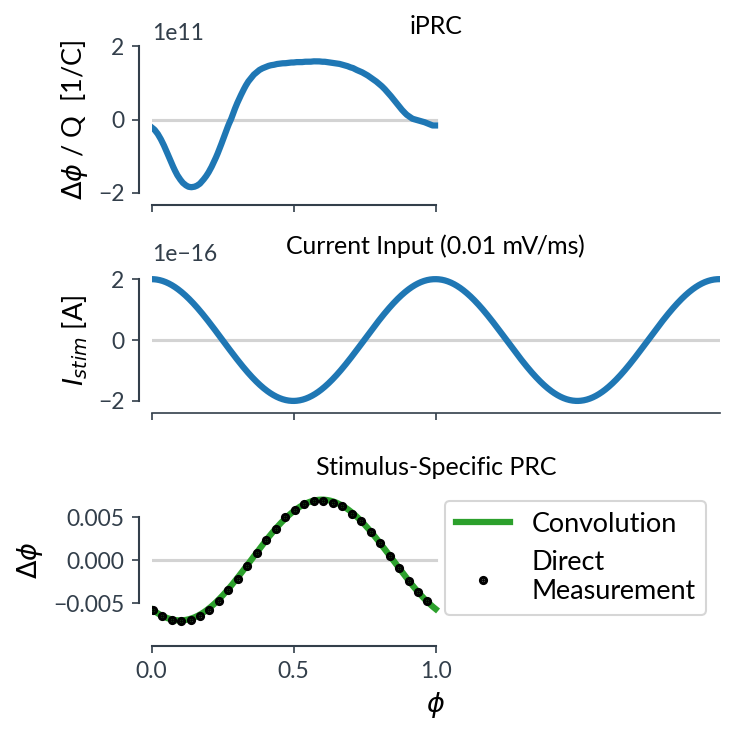

In [11]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

xs = np.linspace(0, prc.frperiod, int(prc.frperiod*10))
sig = iPRC_func(xs)
#win = np.sin(np.linspace(0, 2*np.pi, len(xs)))*2*10**(-14) * 0.01 
win = np.sin(np.linspace(-1.5*np.pi, 0.5*np.pi, len(xs)))*2*10**(-14) * 0.01
win2 = np.concatenate([win, win])
filtered = signal.convolve(sig, win2, mode='valid') 

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True, figsize=(5,5), dpi=150)
ax_orig.plot(sig, lw=3)
ax_orig.set_ylabel(r"$\Delta\phi$ / Q  [1/C]")
ax_orig.set_title('iPRC')
ax_orig.margins(0, 0.1)
ax_win.plot(win2, lw=3)
ax_win.set_ylabel(r"$I_{stim}$ [A]")
ax_win.set_title('Current Input (0.01 mV/ms)')
ax_win.margins(0, 0.1)

ax_filt.plot(filtered, lw=3, color="tab:green", label="Convolution", zorder=3)
prcs_x = np.asarray(list(prc_sine.keys()))[::10]
prcs_y = np.asarray(list(prc_sine.values()))[::10]
ax_filt.scatter(prcs_x/prc.frperiod*len(xs), prcs_y / prc.frperiod, s=2,  c="black", lw=3, label="Direct\nMeasurement", zorder=4)
#ax_filt.grid()
ax_filt.set_ylabel("")
ax_filt.set_title('Stimulus-Specific PRC')
ax_filt.margins(0, 0.1)
ax_filt.legend()
ax_filt.set_xlabel(r"$\phi$")
ax_filt.set_ylabel(r"$\Delta \phi$")
ax_filt.set_xticks([0, 5* prc.frperiod, 10 * prc.frperiod, 15 * prc.frperiod, 20 * prc.frperiod ])
ax_filt.set_xticklabels(['0.0','0.5','1.0','1.5','2.0'])


ax_orig.plot((0, 10*prc.frperiod), (0, 0), color="lightgrey", zorder=1)
ax_orig.tick_params(right=False, top=False)
ax_orig.spines["top"].set_visible(False), ax_orig.spines["right"].set_visible(False)
ax_orig.spines["bottom"].set_bounds(low=0, high=10*prc.frperiod)
ax_orig.set_xticks([0, 5* prc.frperiod, 10 * prc.frperiod])
plt.draw()
ax_orig.set_ylim(-2e11, 2e11)
lab = [float(item.get_text().replace("−", "-")) for item in ax_orig.get_yticklabels(which='both')][1:-1]
ic(min(lab))
ic(max(lab))
ax_orig.spines["left"].set_bounds(low=-2e11, high=2e11)
ax_orig.spines["left"].set_linewidth(1)
ax_orig.spines["left"].set_position(("outward",6))
ax_orig.spines["bottom"].set_linewidth(1)
ax_orig.spines["bottom"].set_position(("outward",6))


ax_win.plot((0, 20*prc.frperiod), (0, 0), color="lightgrey", zorder=1)
ax_win.tick_params(right=False, top=False)
ax_win.spines["top"].set_visible(False), ax_win.spines["right"].set_visible(False)
ax_win.spines["bottom"].set_bounds(low=0, high=20*prc.frperiod)
#ax_win.set_xticks([0, 5* prc.frperiod, 10 * prc.frperiod, 15 * prc.frperiod, 20 * prc.frperiod])
plt.draw()
#ax_win.set_ylim(-2e11, 2e11)
lab = [float(item.get_text().replace("−", "-")) for item in ax_win.get_yticklabels(which='both')][1:-1]
ic(min(lab))
ic(max(lab))
ax_win.spines["left"].set_bounds(low=-2e-16, high=2e-16)
ax_win.spines["left"].set_linewidth(1)
ax_win.spines["left"].set_position(("outward",6))

ax_filt.plot((0, 10*prc.frperiod), (0, 0), color="lightgrey", zorder=1)
ax_filt.tick_params(right=False, top=False)
ax_filt.spines["top"].set_visible(False), ax_filt.spines["right"].set_visible(False)
ax_filt.spines["bottom"].set_bounds(low=0, high=10*prc.frperiod)
ax_filt.set_xticks([0, 5* prc.frperiod, 10 * prc.frperiod])
plt.draw()
#ax_.set_ylim(-2e11, 2e11)

ax_filt.spines["left"].set_bounds(low=-0.005, high=0.005)
ax_filt.spines["left"].set_linewidth(1)
ax_filt.spines["left"].set_position(("outward",6))
ax_filt.spines["bottom"].set_linewidth(1)
ax_filt.spines["bottom"].set_position(("outward",6))

fig.tight_layout()
fig.show()
#fig.savefig("Pics/iPRC_Convolution.pdf")